### Imports

In [1]:
# imports
import numpy as np

import torch
import gpytorch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from tqdm.notebook import tqdm

# Seaborn style for visualization
sns.set_theme(style="whitegrid")

In [2]:
from abc import ABC, abstractmethod


class SpatialCovariance(ABC):
    def __call__(self, w, h):
        xs = torch.linspace(0, 1, w)
        ys = torch.linspace(0, 1, h)
        points = [torch.tensor([x, y], dtype=torch.float) for x in xs for y in ys]
        covar = torch.zeros(len(points), len(points))
        for i in range(len(points)):
            for j in range(i, len(points)):
                x = points[i]
                y = points[j]
                covar[i, j] = self.kernel(x, y)
                covar[j, i] = covar[i, j]
        return covar

    @abstractmethod
    def kernel(self, x, y):
        raise NotImplementedError


class RBFCovariance(SpatialCovariance):
    def __init__(self, a, l):
        self.a = a
        self.l = l

    def kernel(self, x, y):
        diff = torch.norm(x - y)
        return self.a * torch.exp(-(diff**2) / (2 * self.l**2))

### Dataset and dataloader setup

In [3]:
# Set up data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5 and std=0.5
])

# Download and load the MNIST dataset
dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

In [4]:
# Split the training dataset into train and validation subsets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualising images

In [5]:
# Function to visualize a batch of images
def visualize_images(dataloader, title="Images"):
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Denormalize images for visualization
    images = images * 0.5 + 0.5  # Reverse normalization to [0, 1]

    # Set up the figure
    fig, axes = plt.subplots(2, 4, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for img, label, ax in zip(images[:8], labels[:8], axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Display the single-channel image
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

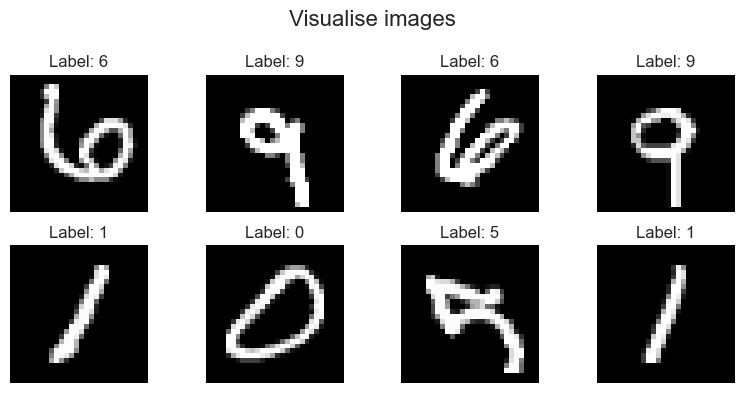

In [6]:
# Visualize train, validation, and test batches
visualize_images(train_loader, title="Visualise images")

### Baseline B-CNN

In [7]:
def KL_DIV(mu_p, sig_p, mu_q, sig_q):
    kl = 0
    kernel_size = sig_q.shape[1]
    blocks = sig_q.shape[0]
    n = sig_q.shape[1]
    sig_p_inv = torch.linalg.pinv(sig_p)
    term_1_2 = torch.logdet(sig_p)
    for i in range(blocks):
        term_1_1 = torch.logdet(sig_q[i,:,:])
        term_1 =  term_1_1 - term_1_2
        term_3 = torch.trace(sig_p_inv @ sig_q[i,:,:])
        mu_diff = (mu_q[kernel_size*i:kernel_size*(i+1)] - mu_p[kernel_size*i:kernel_size*(i+1)])
        loss = (term_1 + n - term_3 - (mu_diff).T @ sig_p_inv @ (mu_diff))
        # print("term11", term_1_1)
        # print("term12", term_1_2)
        # print("term3", term_3)
        # print("sig_p_inv", sig_p_inv)
        kl += loss

    return -0.5*kl


class RBF(gpytorch.kernels.RBFKernel):
    def __init__(self, a, **kwargs):
        super().__init__(**kwargs)
        self.outputscale = a

    def forward(self, x1, x2, **params):
        # covar = super().forward(x1, x2, **params)
        covar = torch.eye(x1.shape[0])
        return covar * self.outputscale

class BBBConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, priors=None, num_samples=1):

        super(BBBConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_shape = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.kernel_size = self.kernel_shape[0] * self.kernel_shape[1]
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_samples = num_samples

        prior_mu = torch.zeros(self.kernel_size*in_channels*out_channels,)
        rbf_kernel = RBFCovariance(1, 1)
        prior_covariance_matrix = rbf_kernel(self.kernel_shape[0], self.kernel_shape[1])

        grid_size = self.kernel_shape[0]
        x = torch.linspace(0, 1, grid_size)
        y = torch.linspace(0, 1, grid_size)
        xx, yy = torch.meshgrid(x, y, indexing="ij")
        self.points = torch.stack([xx.ravel(), yy.ravel()], dim=-1)
        self.counter = 0

        if priors is None:
            priors = {
                'prior_mu': prior_mu,
                'prior_cov': prior_covariance_matrix
            }

        # prior mean and convariance

        self.prior_mu = priors['prior_mu']
        self.prior_cov = priors['prior_cov']

        # kernel for weight paramters (W_mu and W_sigma)
        # a and l are learnable here

        self.a = nn.Parameter(1+torch.rand(in_channels*out_channels))
        self.l = nn.Parameter(1+torch.rand(in_channels*out_channels))

        self.W_mu = nn.Parameter(torch.rand(in_channels*out_channels*self.kernel_size))
        self.sampled_weights = torch.rand((self.num_samples,) + self.W_mu.shape)

    def forward(self, input, sample=True):
        # (B,S,C,H,W)
        if self.training or sample:
            # W_mu, a and l are learnable parameters
            self.sample_weights()

            # now we have sampled "num_samples" at once
            # we iterate through the S dimension and run each set of weights for each sample
            # it is guarenteed that self.num_samples matches with S (except for first layer, where input will have S = 1)
            S = input.shape[1]
            outputs = []
            for i in range(self.num_samples):
                weight = self.sampled_weights[i,:].view(self.out_channels, self.in_channels, self.kernel_shape[0], self.kernel_shape[1])

                input_index = 0 if S == 1 else i
                outputs.append(F.conv2d(input[:,input_index,:,:,:], weight, None, self.stride, self.padding, self.dilation, self.groups))
            return torch.stack(outputs, dim=1)
        else:
            weight = self.W_mu.view(self.out_channels, self.in_channels, self.kernel_shape[0], self.kernel_shape[1])
            return F.conv2d(input[:,0,:,:,:], weight, None, self.stride, self.padding, self.dilation, self.groups)

    def kl_loss(self):
        return KL_DIV(self.prior_mu, self.prior_cov, self.W_mu, self.W_cov)

    def sample_weights(self):
        blocks = []
        for i in range(self.in_channels*self.out_channels):
            # different a and l for different filter (x,y)
            rbf_kernel = RBFCovariance(self.a[i], self.l[i])

            filterwise_covariance_matrix = rbf_kernel(self.kernel_shape[0], self.kernel_shape[1])
            jitter = 1e-6 * torch.eye(filterwise_covariance_matrix.size(0))
            filterwise_covariance_matrix += jitter

            # samples "num_samples" weights at once
            mvn = torch.distributions.MultivariateNormal(self.W_mu[self.kernel_size*i : self.kernel_size*i+self.kernel_size], filterwise_covariance_matrix)
            self.sampled_weights[:, self.kernel_size*i : self.kernel_size*i+self.kernel_size] = mvn.sample((self.num_samples,))

            self.counter+=1

            blocks.append(filterwise_covariance_matrix)

        self.W_cov = torch.stack(blocks) # concats only the blocks of the block diagonal covariance matrix

class BayesianCNN(nn.Module):
    def __init__(self, num_samples=1):
        super(BayesianCNN, self).__init__()
        self.conv1 = BBBConv2d(1, 32, kernel_size=3, stride=1, padding=1, num_samples=num_samples)
        self.conv2 = BBBConv2d(32, 64, kernel_size=3, stride=1, padding=1, num_samples=num_samples)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.num_samples = num_samples

    def forward(self, x_in):
        x = x_in.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        y=[]
        for i in range(self.num_samples):
            y.append(self.pool(x[:,i,:,:,:]))
        y = torch.stack(y, dim=1)
        y = y.view(y.size(0), y.size(1), -1)  # Flatten
        y = torch.relu(self.fc1(y))
        y = self.fc2(y)
        y = F.log_softmax(y, dim=2)

        kl = 0.0
        for module in self.children():
            if hasattr(module, 'kl_loss'):
                module_kl_loss = module.kl_loss()
                kl = kl + module_kl_loss

        return y, kl

class NonBayesianCNN(nn.Module):
    def __init__(self):
        super(NonBayesianCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [8]:
model=BBBConv2d(1,32,3,num_samples=100)
model(torch.rand(64, 1, 1, 9, 9)).shape

torch.Size([64, 100, 32, 7, 7])

In [9]:
model = BayesianCNN(num_samples=100)
out = model(torch.rand(64, 1, 28, 28))


/var/folders/92/fmjkh__50rq2yj5c9sl265y80000gn/T/ipykernel_9622/642770217.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  loss = (term_1 + n - term_3 - (mu_diff).T @ sig_p_inv @ (mu_diff))


In [10]:
out[0].shape

torch.Size([64, 100, 10])

In [11]:
out[0].shape, out[1]

(torch.Size([64, 100, 10]), tensor(272240.8438, grad_fn=<AddBackward0>))

### Train and evaluate

In [21]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        # with tqdm(data_loader, unit="batch") as tepoch:
        #     tepoch.set_description("Evaluating")
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            if len(outputs) == 2: outputs = outputs[0]

            # Compute predictions and update accuracy metrics
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Display current accuracy in the progress bar
            accuracy = 100 * correct / total
    accuracy = 100 * correct / total  # Overall accuracy
    return accuracy

def train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=None, use_kl=True):
    # Total number of batches across all epochs
    total_steps = len(train_loader) * epochs
    losses = []
    val_accuracies = []

    # Single progress bar for all epochs
    with tqdm(total=total_steps, unit="batch") as pbar:
        for epoch in range(epochs):
            model.train()
            total_combined_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # # One-hot encode labels
                # one_hot_labels = F.one_hot(labels, num_classes=10).float()

                # Forward pass
                outputs = model(images)
                if len(outputs) == 2:
                    logits, kl_loss = outputs
                else:
                    logits = outputs

                # # Apply softmax to logits
                # softmax_outputs = F.softmax(logits, dim=1)

                # Cross entropy loss
                if len(logits.shape) == 3:
                    logits = logits.permute(0, 2, 1) # (batch_size, num_samples, num_classes) -> (batch_size, num_classes, num_samples)
                    labels = labels.unsqueeze(-1) # (batch_size, ) -> (batch_size, 1)
                    labels = labels.expand(-1, logits.shape[-1]) # (batch_size, 1) -> (batch_size, num_samples)
                    cross_entropy_loss = F.cross_entropy(logits, labels, reduction='none') # (batch_size, num_samples)
                    cross_entropy_loss = cross_entropy_loss.mean(-1) # average over samples
                    cross_entropy_loss = cross_entropy_loss.sum() # sum over minibatch
                else:
                    cross_entropy_loss = F.cross_entropy(logits, labels, reduction='sum')

                combined_loss = 0.0
                if criterion: combined_loss += cross_entropy_loss
                if use_kl: combined_loss += kl_loss

                # Backward pass
                optimizer.zero_grad()
                combined_loss.backward()
                optimizer.step()

                # Update metrics
                total_combined_loss += combined_loss.item()

                # Update the progress bar dynamically
                pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
                pbar.set_postfix(combined_loss=combined_loss.item())
                pbar.update(1)

            avg_combined_loss = total_combined_loss / len(train_loader)
            losses.append(avg_combined_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Avg Combined Loss: {avg_combined_loss:.4f}")
            val_acc = evaluate(model, val_loader, device)
            val_accuracies.append(val_acc)
            print(f"Val Acc: {val_acc:.2f}%")

    print("Training complete.")

    test_acc = evaluate(model, test_loader, device)
    print(f"Testing complete. Test Acc: {test_acc:.2f}%")

    # Create a line plot
    sns.lineplot(x=np.arange(epochs), y=losses)

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")

    # Show the plot
    plt.show()

    # Create a line plot
    sns.lineplot(x=np.arange(epochs), y=val_accuracies)

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.title("Val Accuracy vs. Epoch")

    # Show the plot
    plt.show()

### Train Non Bayesian CNN

In [22]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = NonBayesianCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=criterion, use_kl=False)

  0%|          | 0/7500 [00:00<?, ?batch/s]

KeyboardInterrupt: 

### Train Bayesian CNN

In [23]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = BayesianCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_validate_and_evaluate(model, optimizer, device, epochs, train_loader, test_loader, val_loader, criterion=criterion, use_kl=True)

  0%|          | 0/7500 [00:00<?, ?batch/s]

KeyboardInterrupt: 